<a href="https://colab.research.google.com/github/glouwa/app-kandinsky-pattern-generator/blob/master/lstm_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py

In [2]:
from IPython.display import SVG
from random import seed, randint
from numpy import array, argmax
import numpy as np
import keras
import lib

Using TensorFlow backend.


# Intro
this tutorial is made to learn keras datagenerators.

a small LSTM, procesing a input seqence of symbols and predicting a outputsymbol seqience is used snice data can be easyly generated.

format sings are used to gernated x samples, phython eval is used on the X to generate the Y values.

we a building a calculator.

### Encoding
a seqence of onehot encoded symbols s element alphabet, 
user defines input symbol seq len and output.

X.shape = (samples,  in_seqlen,  alphalen)   
Y.shape = (samples, out_seqlen,  alphalen)  

### Predicting a Sample
user will input a string, and want to read a string

for prediction encode -> predict -> decode is neccesary 
  
  
 

In [3]:
#@title Define context, sample dimensins { vertical-output: true }
alphabet        = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '*', ' '] #@param {type:""}

in_seq_len      = 5 #@param {type:"slider", min:2, max:20, step:1}
out_seq_len     = 4 #@param {type:"slider", min:1, max:10, step:1}
  
input_shape     = (in_seq_len,  len(alphabet))
output_shape    = (out_seq_len, len(alphabet))

print('input_shape:', input_shape, 'output_shape:', output_shape)

input_shape: (5, 14) output_shape: (4, 14)


In [0]:
int_to_char    = dict((i, c) for i, c in enumerate(alphabet))  
char_to_int    = dict((c, i) for i, c in enumerate(alphabet))

to_onehot      = lambda val: [1 if val==i else 0 for i in range(len(alphabet))] 

sample_encode  = lambda stg:         [to_onehot(char_to_int[char]) for char in stg]
sample_decode  = lambda soh: ''.join([int_to_char[argmax(step)] for step in soh])  

padd_r         = lambda s,l: s + ''.join([' ' for _ in range(l-len(s))])  
padd_l         = lambda s,l:     ''.join([' ' for _ in range(l-len(s))]) + s
padd           = padd_l

In [0]:
class Sample:  
  def __init__(self, x, y):    
    self.x = {
        'str': x,
        'hot': sample_encode(x) 
    }
    self.y = {
        'str': y,
        'hot': sample_encode(y)
    }      
  def __str__(self):
    return "'{}' = '{}'".format(self.x['str'], self.y['str'])

### Generating samples
data is generated as sting expresssin, by a formatstring, which is filled with random numbers [0,  max_int] 

a saple is created with its various encodings

In [6]:
#@title Create a sample by a given format string. calculate encodings. check encode/decode. { vertical-output: true }
max_int         = 40 #@param {type:"slider", min:10, max:100, step:1}

in_seq_format   = '{:d}*{:d}' #@param
in_seq_vars     = 2 #@param
out_seq_format  = '{:d}' #@param {type:"raw"}
out_seq_vars    = 'eval in seq' #@param {type:"raw"}

formatparams    = [in_seq_format, in_seq_len, out_seq_len, out_seq_format, out_seq_len]

def SampleFromFormat(xt, in_seq_len, c, yt, out_seq_len):
  xstr = xt.format(*[randint(0, max_int) for _ in range(c)])
  ystr = yt.format(eval(xstr))
  xstr = padd(xstr, in_seq_len)
  ystr = padd(ystr, out_seq_len)
  return Sample(xstr, ystr)

s = SampleFromFormat(*formatparams)
print("generated string:", s)
print("encoded and back: '{}' = '{}'".format(sample_decode(s.x['hot']), sample_decode(s.y['hot'])))

generated string: ' 29*3' = '  87'
encoded and back: ' 29*3' = '  87'


# Ok, we have a Sample class - now lets make a Keras DataGenerator

create some samples, and extracts the enhot encoded seqences X and y as a numpy arrays


In [7]:
#@title Now lets generate a set of such Samples { vertical-output: true }
def generate_data(n_samples):  
  X = list()
  y = list()
  for i in range(0, n_samples):
    s = SampleFromFormat(*formatparams) 
    X.append(s.x['hot'])
    y.append(s.y['hot'])
    
  return array(X), array(y) 

generate_data(1)

(array([[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]),
 array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]))

In [0]:
#@title Data Generators are the adapter to keras{ vertical-output: true }
batch_size      = 300 #@param {type:"slider", min:50, max:300, step:10}
training_size   = 3200 #@param {type:"slider", min:1000, max:3200, step:100}
validation_size = 400 #@param {type:"slider", min:10, max:500, step:10}
test_size       = 400 #@param {type:"slider", min:10, max:500, step:10}

class DataGenerator(keras.utils.Sequence):
    'Generates kandinsky data for Keras'
    def __init__(self, samples=1000, batch_size=32, in_dim=(), out_dim=()):        
        self.n_samples = samples
        self.batch_size = batch_size
        self.in_dim = in_dim                
        self.out_dim = out_dim
        print('DataGenerator: samples=', self.n_samples, "batchsize=", 
              self.batch_size, "len=", int(np.floor(self.n_samples / self.batch_size)))
        
    def __len__(self):
        'Denotes the number of batches per epoch'        
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, index):        
        #indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]        
        #list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        X = np.empty((self.batch_size, *self.in_dim))
        y = np.empty((self.batch_size), dtype=int)        
        #print("Xy shapes: ", X.shape, y.shape)
        X, y = generate_data(self.batch_size)
        #print("Xy shapes: ", X.shape, y.shape)
        return X, y

In [9]:
#@title Train/Test/Validate Generators { vertical-output: true, output-height: 200 }
params = {
    'batch_size': batch_size,
    'in_dim': input_shape,    
    'out_dim': output_shape
}

training_generator =   DataGenerator(samples=training_size, **params)
validation_generator = DataGenerator(samples=validation_size, **params)
test_generator =       DataGenerator(samples=test_size, **params)

view_generator =       DataGenerator(samples=1, **params)
view_generator[0][0].shape, view_generator[0][1].shape

DataGenerator: samples= 3200 batchsize= 300 len= 10
DataGenerator: samples= 400 batchsize= 300 len= 1
DataGenerator: samples= 400 batchsize= 300 len= 1
DataGenerator: samples= 1 batchsize= 300 len= 0


((300, 5, 14), (300, 4, 14))

# Data is ready - Time for the network

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               46000     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 50)             30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 14)             714       
Total params: 76,914
Trainable params: 76,914
Non-trainable params: 0
_________________________________________________________________
None


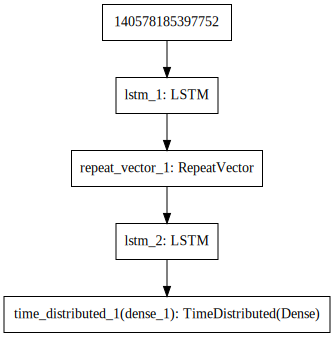

In [10]:
#@title Any LSTM configuration { vertical-output: true, output-height: 200 }
loss         = "categorical_crossentropy" #@param ["categorical_crossentropy", "whatever"]
optimizer    = "adam"                     #@param ["adam" ,"other"]
main_metric  = "accuracy"                 #@param ["accuracy"]
n1           = 100 #@param {type:"slider", min:1, max:500, step:1}
n2           = 50 #@param {type:"slider", min:1, max:500, step:1}
  
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, RepeatVector
  
model = Sequential()
model.add(LSTM(n1, input_shape=input_shape))
model.add(RepeatVector(out_seq_len))
model.add(LSTM(n2, return_sequences=True))
model.add(TimeDistributed(Dense(len(alphabet), activation='softmax')))
model.compile(loss=loss, optimizer=optimizer, metrics=[main_metric])

print(model.summary())
SVG(keras.utils.vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

Instructions for updating:
Use tf.cast instead.


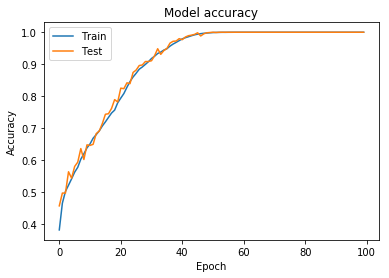

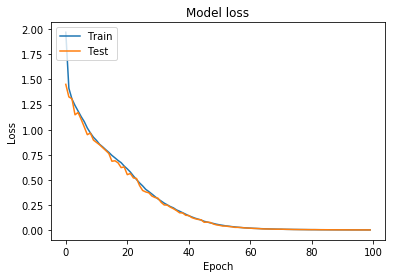

CPU times: user 14min 41s, sys: 5min 24s, total: 20min 6s
Wall time: 14min 57s


In [11]:
#@title Training { vertical-output: true }
%%time
epochs             = 100 #@param {type:"slider", min:2, max:500, step:1}
use_multprocessing = True #@param {type:"boolean"}
workers            = 16 #@param {type:"slider", min:1, max:20, step:1}
verbose            = 0 #@param {type:"slider", min:0, max:5, step:1}

history = model.fit_generator(
  generator = training_generator,
  validation_data = validation_generator,                    
  epochs = epochs,
  steps_per_epoch = 100,
  use_multiprocessing = use_multprocessing,
  workers = workers,
  verbose = verbose,
  )#callbacks = [keras.callbacks.EarlyStopping(monitor='val_acc', sensible=2)])

lib.plot_history(history)

# Training done - Time for evaluatoin

In [12]:
#@title Show some errors by sample { vertical-output: true }
max_errors = 18 #@param {type:"slider", min:1, max:20, step:1}


# evaluate on some new patterns
X, y = generate_data(1000)
print(X.shape, y.shape)

result = model.predict(X, verbose=1)

expected =  [sample_decode(s) for s in y]
predicted = [sample_decode(s) for s in result]

c = 0
for i in range(0, len(result)):
  if expected[i] != predicted[i]:
    c = c + 1
    if c < max_errors:
      print('Expected=%s, Predicted=%s' % (expected[i], predicted[i]))  
      
print("expected != predicted Count:", c)

(1000, 5, 14) (1000, 4, 14)
1000/1000 [==============================] - 0s 233us/step
expected != predicted Count: 0


In [13]:
#@title Test Metrics { vertical-output: true }
"Accuracy %s" % model.evaluate_generator(test_generator)[1]

'Accuracy 1.0'

In [30]:
#@title Use the trained Model  { vertical-output: true }
def calculate(inp):
  print(inp, '=')
  padded = padd(inp, in_seq_len)  
  X = array([sample_encode(padded)])  
  result = model.predict(X)
  return sample_decode(result[0])

print(calculate('3*7'), "should be", 3*7)
print(calculate('13*18'), "should be", 13*18)
print(calculate('3*43'), "(extrapolated) should be", 3*43)

3*7 =
  21 should be 21
13*18 =
 234 should be 234
3*43 =
 132 (extrapolated) should be 129
